In [83]:
import pickle
from functools import partial
from os import listdir
from os.path import isfile, join

import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from common import CityResult
from file_name_generator import generate_new_name


In [84]:
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rcParams.update({'font.size': 30})
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = False

In [85]:
class CentroidResult:
    def __init__(self, resolution: float,
                 centroid_nodes: int,
                 centroid_edges: int,
                 alpha: float
                 ):
        self.resolution: float = resolution
        self.centroid_nodes: int = centroid_nodes
        self.centroid_edges: int = centroid_edges
        if centroid_nodes == 1:
            self.centroid_density = 0
        else:
            self.centroid_density = 2 * centroid_edges / (centroid_nodes * (centroid_nodes - 1))
        self.alpha: float = alpha
        self.speed_up: list[float] = []
        self.errors: list[float] = []
        self.absolute_time: list[float] = []
        self.absolute_err: list[float] = []


class CityResult:
    def __init__(self,
                 name: str,
                 name_suffix: str,
                 city_id: str,
                 nodes: int,
                 edges: int
                 ):
        self.name = name
        self.name_suffix: str = name_suffix
        self.id: str = city_id
        self.nodes: int = nodes
        self.edges: int = edges
        self.density: float = 2 * edges / (nodes * (nodes - 1))
        self.points_results: list[CentroidResult] = []
    def save(self):
        file_name = generate_new_name(self.name + self.name_suffix + '.pkl')
        with open(file_name, 'wb') as fp:
            pickle.dump(self, fp)
            fp.close()


Загрузка данных

In [86]:
mypath = '../for_paper/data/real_cities'

In [87]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

r : dict[str:CityResult]= {}
for name in onlyfiles:
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

In [88]:
mypath = '../for_paper/data/not_my'

In [89]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

r : dict[str:CityResult]= {}
for name in onlyfiles:
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

In [90]:
mypath = '../for_paper/data/data/data_csv'

In [91]:
# import networkx as nx
# from tqdm import tqdm
# import csv
# import osmnx as ox
# 
# 
# def get_graph(city_id: str = 'R2555133') -> nx.Graph:
#     gdf = ox.geocode_to_gdf(city_id, by_osmid=True)
#     polygon_boundary = gdf.unary_union
#     graph = ox.graph_from_polygon(polygon_boundary,
#                                   network_type='drive',
#                                   simplify=True)
#     G = nx.Graph(graph)
#     H = nx.Graph()
#     # Добавляем рёбра в новый граф, копируя только веса
#     for u, d in G.nodes(data=True):
#         H.add_node(u, x=d['x'], y=d['y'])
#     for u, v, d in G.edges(data=True):
#         H.add_edge(u, v, length=d['length'])
#     del city_id, gdf, polygon_boundary, graph, G
#     return H
# 
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# for name in tqdm(onlyfiles):
#     if 'mistakes_' in name:
#         continue
#     with open(join(mypath, name), 'r') as f:
#         csv_reader = csv.DictReader(f)
#         data = [row for row in csv_reader]
#         id = name.split('_')[1].split('.')[0]
#         nn = 'graph_' + id +'.graphml'
#         G = nx.read_graphml('../for_paper/data/data/data_graphs/'+nn)
#         r = CityResult(name, '',name, len(G.nodes), len(G.edges))
#         # print(name,data,)
#         for d in data:
#             cr = CentroidResult(1, 2,2,float(d['ks']))
#             cr.speed_up.append(float(d['dijkstra_time'])/float(d['times']))    
#             r.points_results.append(cr)
#         r.save()

Обработка данных

In [92]:
USE_OPT_CONST = True # использовать ли фиттинг С0 для каждого города

In [93]:
print(len(r))

630


0.5988124049247483 0.22197466565313342 3503
2.3270721690419935 0.3231411424670836 5242
0.8643212152060801 0.31516420349919444 3053
2.0588337870422238 0.12142120868463079 3288
2.5186581884756776 0.270521751292125 4430
1.6430460245763878 0.2998357114812158 23393
1.403438397968229 0.14819906070449446 20694
1.453949789123173 0.1036281076176262 3997
2.936481039791415 0.26749522852924357 4179
1.6928296470688335 0.10925267209807275 4818
0.9976977049083466 0.12242092570550916 13651
1.7359204752772561 0.12230915779702109 3197
1.7289119539670565 0.16299106977475125 7685
1.8924451261341193 0.10385756851403243 3892
2.66882880760592 0.17788746464636676 3482
2.2426850805669822 0.14077594278778263 4440
1.8101115169678934 0.17515828545988038 2514
0.871828955918669 0.17123237359838112 13951
1.7054122383294759 0.16702932214323638 7705
2.182792743204152 0.2343131390923279 2868
1.5590594640406898 0.1154320279064026 8919
3.6463407364718026 0.5380742350298144 4284
1.5470482148951794 0.11313904468427703 3461

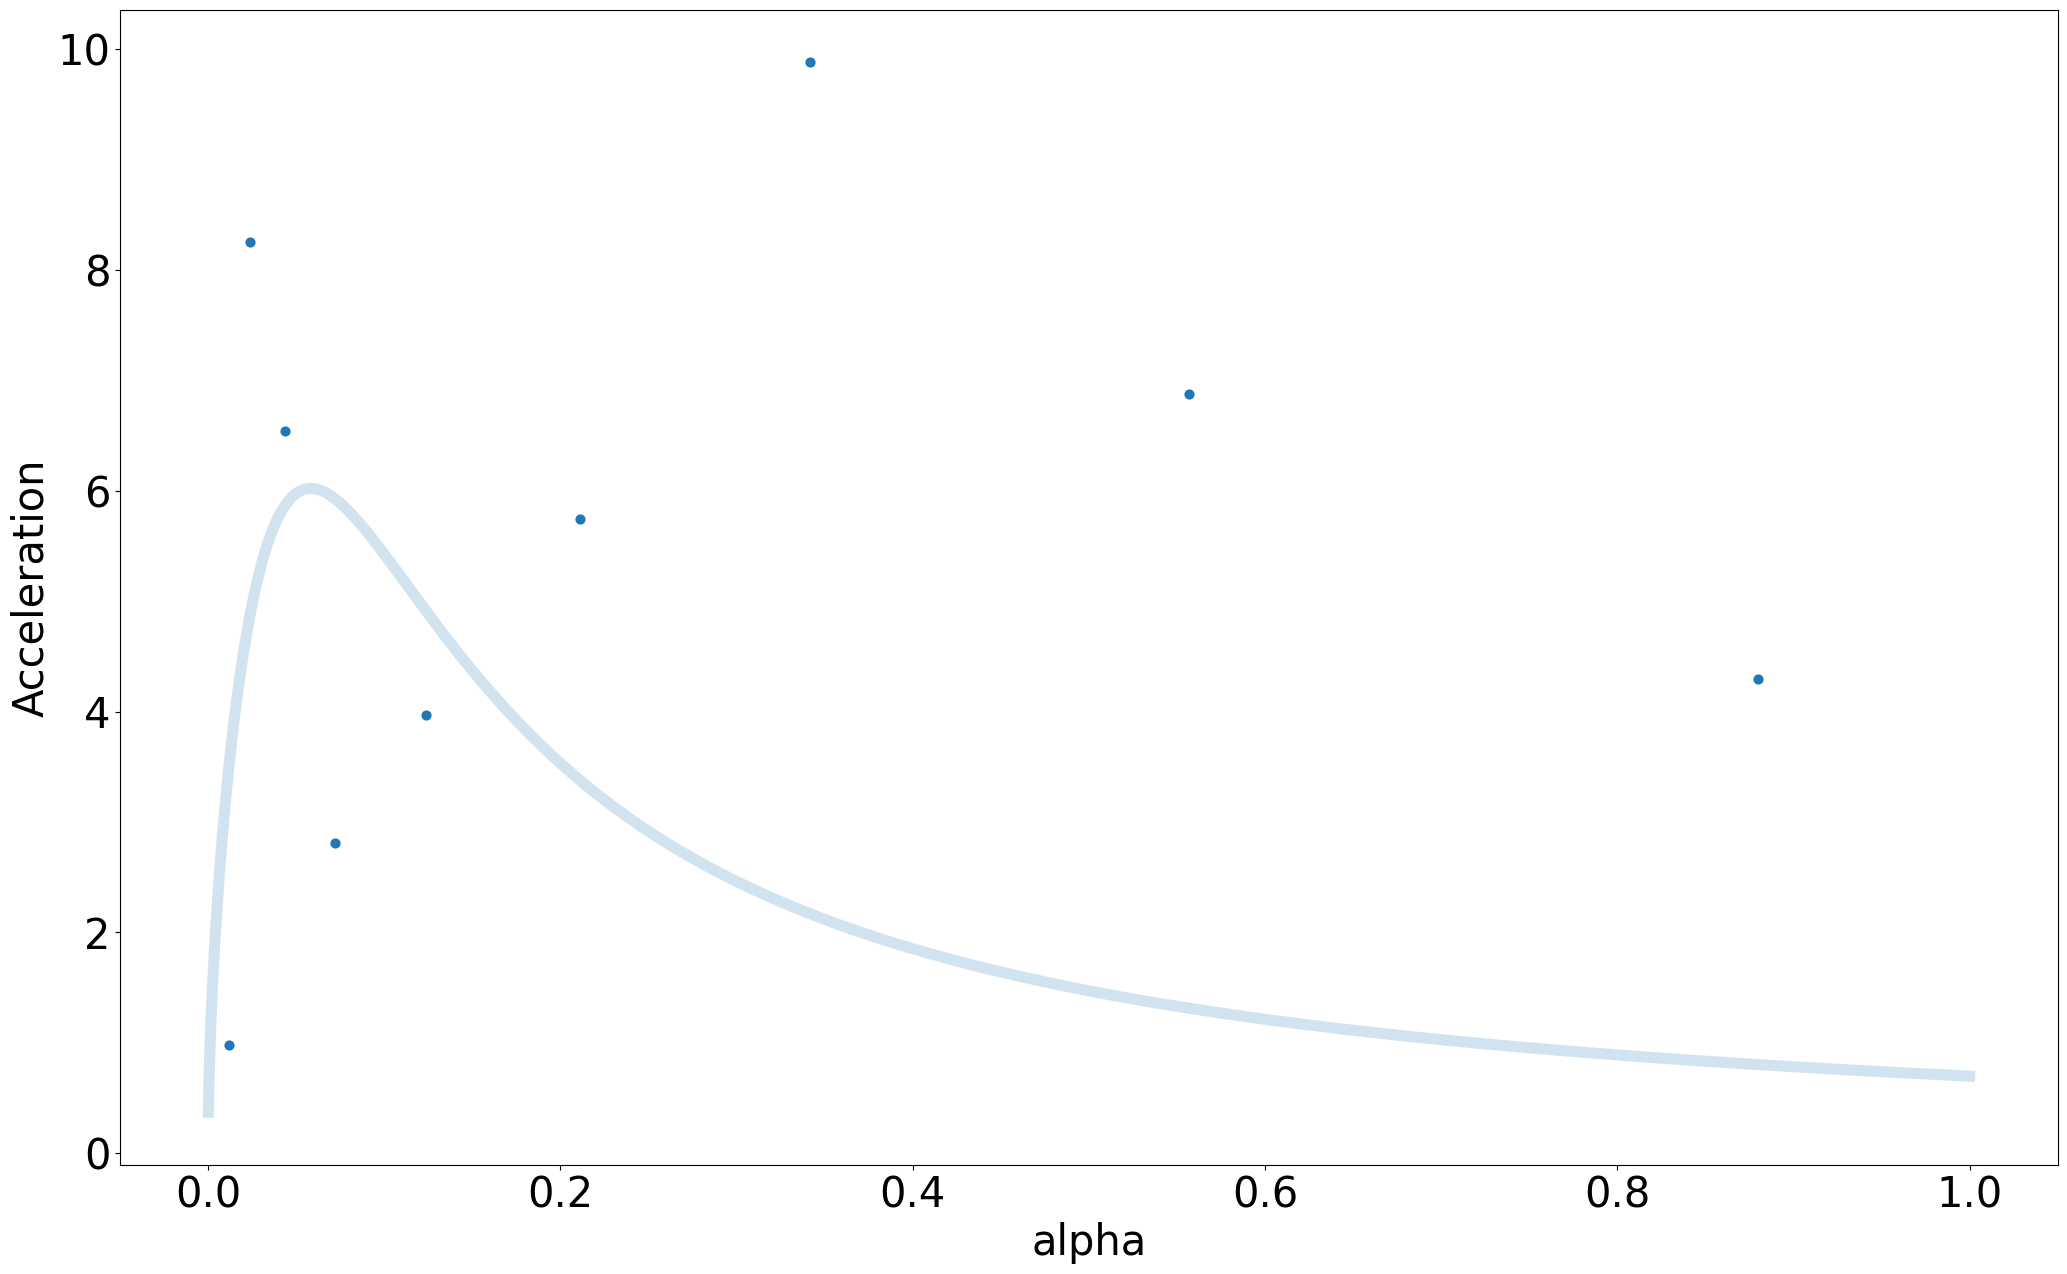

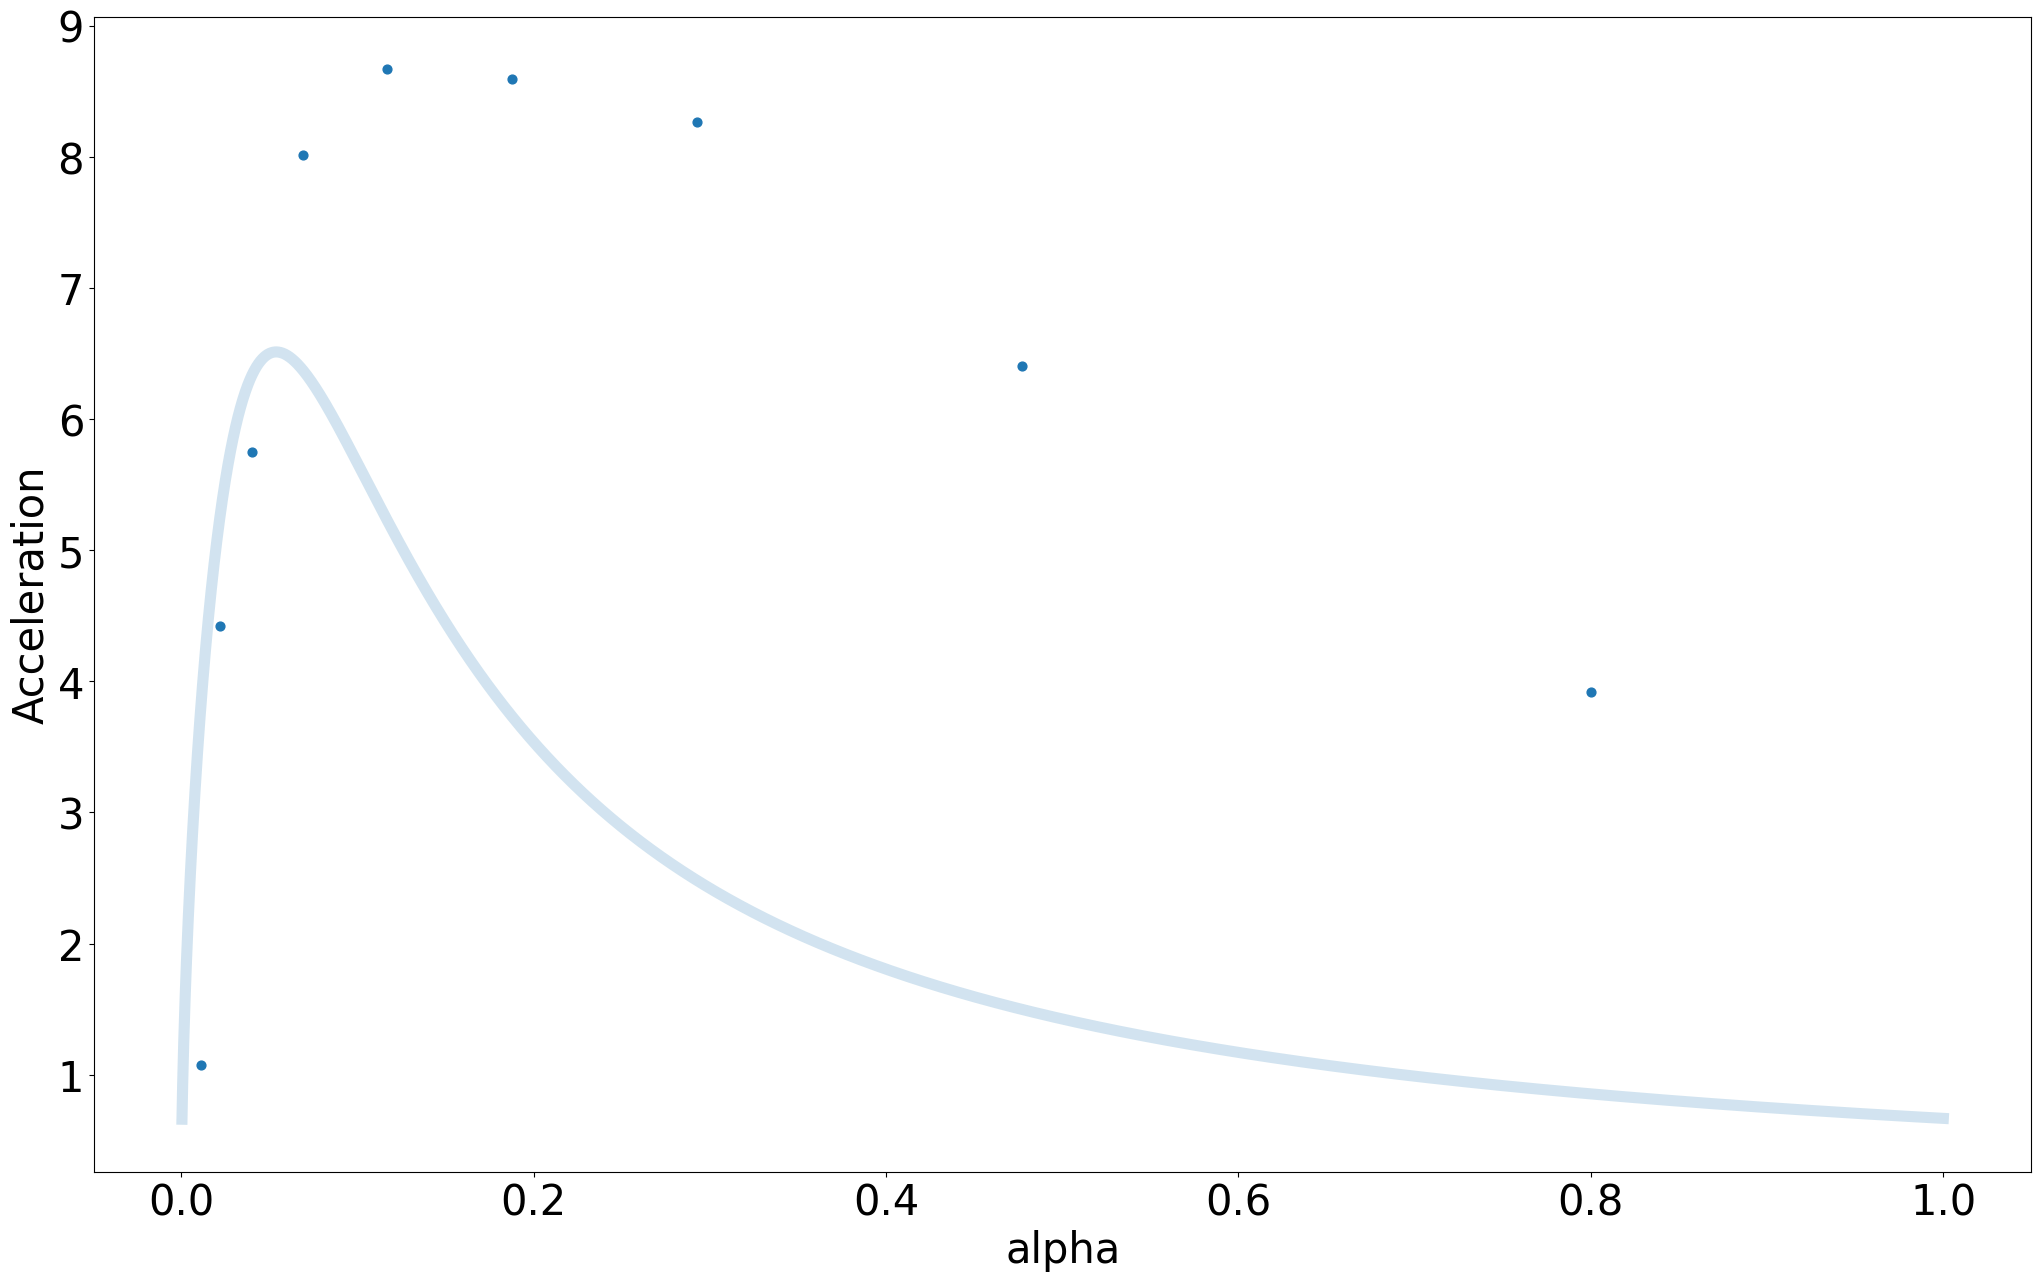

In [137]:
nodes = []
alpha_max = []
c = []
k = 0
for i,name in enumerate(r):
    if name == 'output_R62145.csv.pkl':
        continue
    # if name!='PARIS.pkl':
    #     continue
    res:CityResult = r[name]
    N= res.nodes
    if max(p.speed_up[0] for p in res.points_results) > 20:
        continue
    if name == 'output_R1390623.csv.pkl':
        print(max(p.speed_up[0] for p in res.points_results))
    if N < 2000:
        continue
    alpha_max.append(max(p.speed_up[0] for p in res.points_results))
    k+=1
    X = [p.alpha for p in res.points_results]
    A = [p.speed_up[0] for p in res.points_results]
    E = [np.mean(p.errors) for p in res.points_results]


    # axs[1].errorbar(X, E, fmt='o', label = "{}: {}".format(name, r[name].nodes))
    # axs[1].set(xlabel='alpha', ylabel='Err')
    # axs[1].legend()
    
    alpha = np.argmax(A)
    # alpha_max.append(X[alpha])
    nodes.append(res.nodes)
    def ax(x,c0):
        # c0 = -0.48 * np.log(N) + 6
        b1 =2
        b0 = res.edges/res.nodes
        k = c0/np.sqrt(x*N)*(1 - np.log(x)/np.log(N)) + b1/b0 * x * (1 + np.log(x)/np.log(N)) +1/(np.sqrt(x*N)) * (b0+1)/b0/np.log(N)
        return 1/k
    if USE_OPT_CONST:
        # Xx = np.array(X)
        # Aa = np.array(A)
        # idx = np.argwhere(Xx < 0.2)
        # idx.resize(len(idx))
        # Xx = Xx[idx]
        # Aa = Aa[idx]
        popt = curve_fit(ax, X, A, p0 = [2])
        x = np.linspace(1/N,1,5000)
        y = ax(x, *popt[0])
        c.append(popt[0][0])
        dd = popt[0][0]/ np.sqrt(popt[1][0][0])
        print(popt[0][0], np.sqrt(popt[1][0][0]),N)
        # print(*popt[0])
    else:
        x = np.linspace(1/N,1,5000)
        y = ax(x)
    
    
    # axs[0].errorbar(x, y, color="black",linewidth=4)
    # print(i)
    if dd < 2:
        print(name, dd)
        fig, axs = plt.subplots(1, 1)
        # fig.rc('legend', fontsize=8)    # legend fontsize
        # fig.rcParams.update({'font.size': 20})
        fig.set_figwidth(25)
        fig.set_figheight(15)
        axs=[axs]
        if name!='output_R1390623.csv.pkl':
            axs[0].errorbar(x, y,linewidth=8,alpha=0.2)
        
        axs[0].scatter(X, A, label = "{}: {}".format(name, r[name].nodes), s = 40)
        axs[0].set(xlabel='alpha', ylabel='Acceleration')
        # axs = [axs]
        # axs[0].legend()
    # print(X)
    # print(A)
    

In [117]:
alpha_max.sort()
print(alpha_max)

[2.1444501629782122, 2.311739580636811, 2.318596672923814, 2.3237573303546495, 2.3811940508916614, 2.504326697642696, 2.5965487112276104, 2.6183264030108964, 2.621483870967742, 2.6516488329891748, 2.6697308488612834, 2.698329222320473, 2.698329222320473, 2.7159688131677737, 2.733977229116029, 2.7442005155097324, 2.8096292568361014, 2.827733613319334, 2.8508734351944405, 2.863943161634103, 2.8759921657561076, 2.881841475196371, 2.884886048163213, 2.909705882352941, 2.9254896726617505, 2.9689206014749545, 2.971409090909091, 2.9896711635750424, 3.0128342245989304, 3.013098486727859, 3.018812259206553, 3.0347419507575757, 3.0437461990675048, 3.05028378857751, 3.056347923838966, 3.0856693620844564, 3.091150072082965, 3.1085581515425327, 3.112825490327331, 3.1192643911639886, 3.1206122166943064, 3.168280358598207, 3.1744357654512076, 3.1843982169390785, 3.1861609139325933, 3.1888947576918, 3.1956239280702667, 3.202154026407102, 3.2029426456564187, 3.2061411074693806, 3.2101416731310985, 3.21

<ErrorbarContainer object of 3 artists>

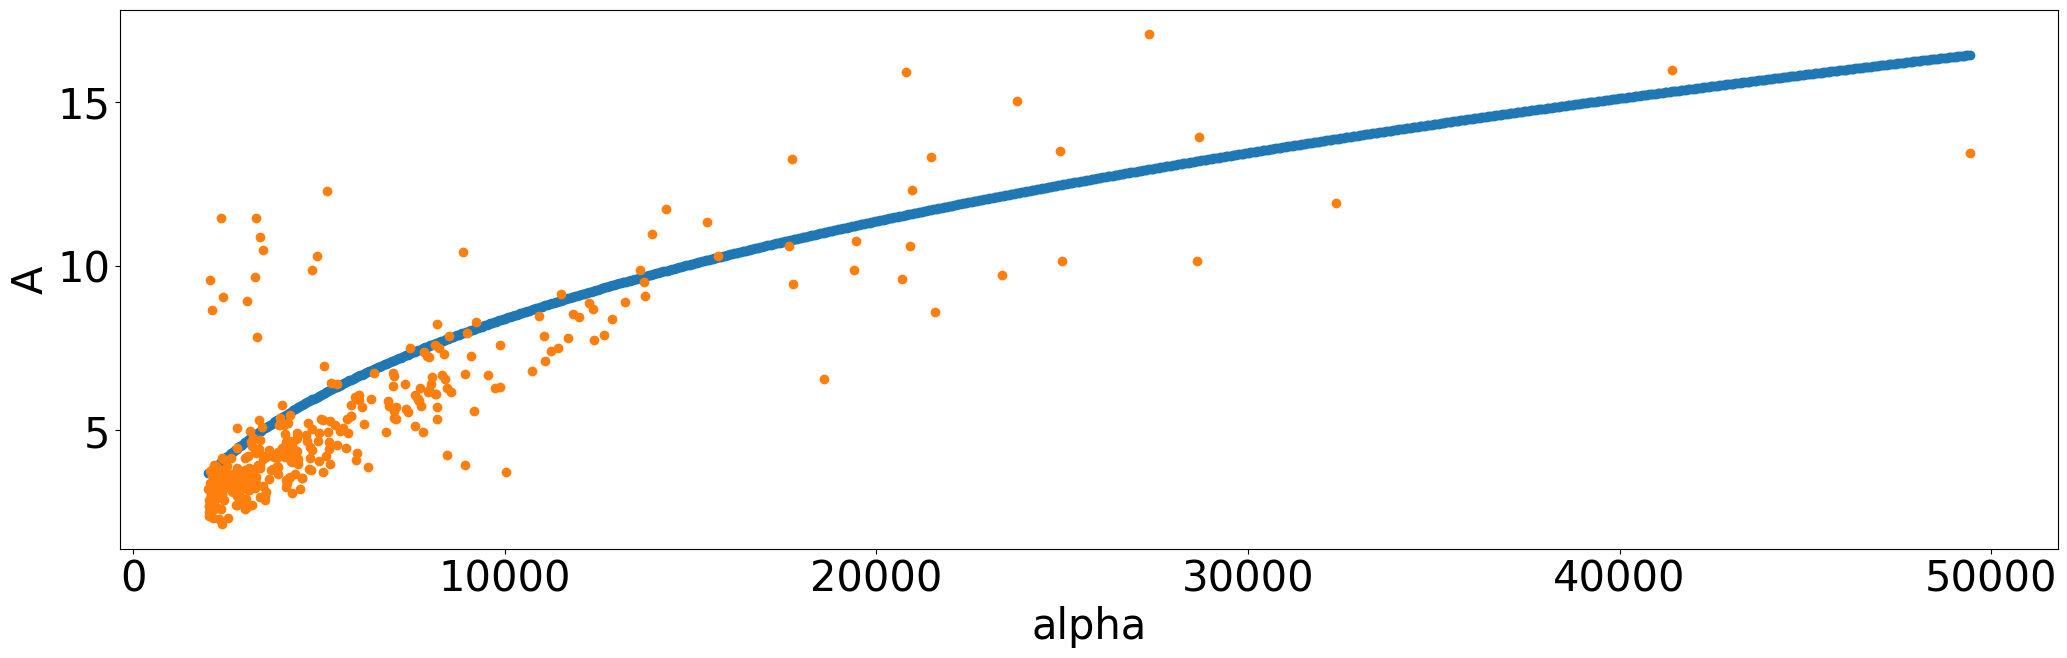

In [133]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(25)
fig.set_figheight(7)
def f(x):
    return 4 ** (1/3) * x ** (1/3)/3 - 3
x = np.linspace(min(nodes), max(nodes), 1000)
y = f(x)
axs.errorbar(x, y, fmt='o', label = "{}: {}".format(name, r[name].nodes))
# axs.errorbar(nodes, alpha_max, fmt='o', label = "{}: {}".format(name, r[name].nodes))


axs.set(xlabel='alpha', ylabel='A')
# axs.legend()
axs.errorbar(nodes, alpha_max, fmt='o', label = "{}: {}".format(name, r[name].nodes))

[-0.52921578  6.45918204]


<ErrorbarContainer object of 3 artists>

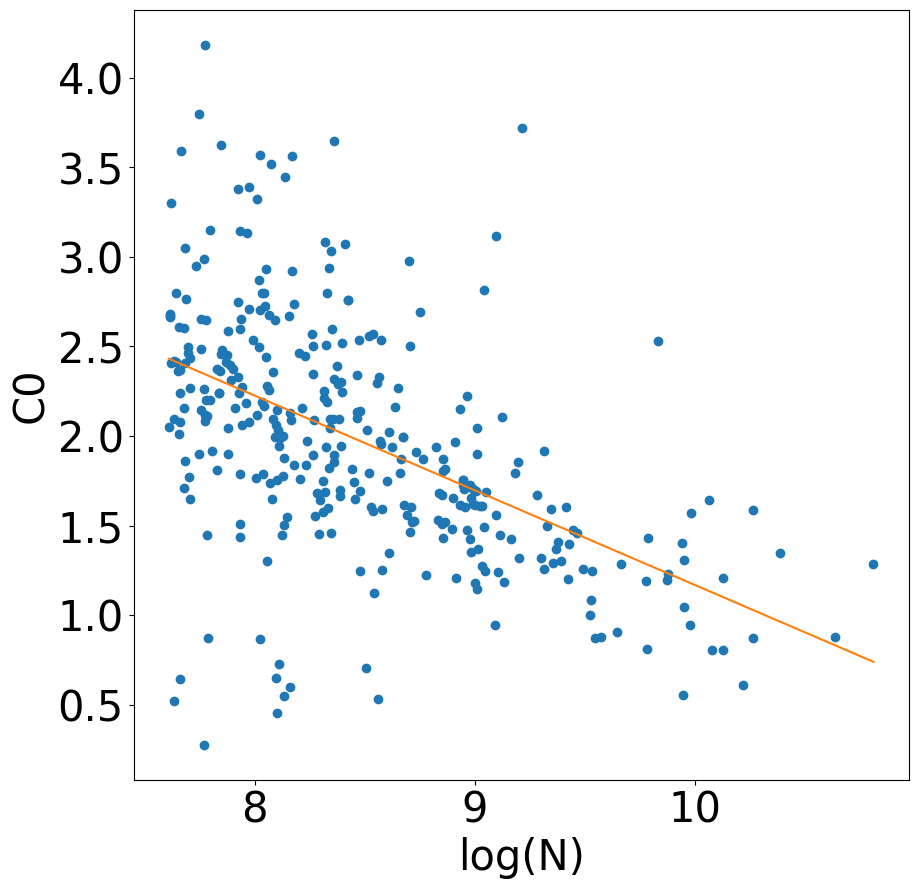

In [138]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(10)

axs.set(xlabel='log(N)', ylabel='C0')
# axs.legend()
# 
def f(x,a,b):
    return a*x+b
        
# x = np.linspace(np.log(min(nodes)), np.log(max(nodes)), 1000)
# y = f(x)

# axs.errorbar(x,y)
indx = np.argsort(nodes)
n = np.array(nodes)[indx]
n = np.log(n)
cc = np.array(c)[indx]
# cc[6]-=0.25
axs.errorbar(n, cc, fmt='o')
# axs.errorbar(nodes, /alpha_max, fmt='o', label = "{}: {}".format(name, r[name].nodes))
popt = curve_fit(f, n, cc, p0 = [-1,1])
print(popt[0])
x = np.linspace(np.log(min(nodes)), np.log(max(nodes)), 1000)
y = f(x,*popt[0])
# 
axs.errorbar(x,y)


Графики:

Построим график ускорения от плотности

Уберем последние 4 точки